# Fashion MNIST with Keras

This notebook shows a Convolutional Neural Network (CNN) being trained over [Fashion MNIST Dataset](https://github.com/zalandoresearch/fashion-mnist) proposed by [Zalando](https://zalando.com/).

Code is based on a [pyimagesearch post](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/) with some customizations. :)

## Base code

As a good practice, I use to keep some base source code externally to the notebook, which is accomplished by the following code.

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import sys
cwd = os.getcwd()
if cwd not in sys.path:
    sys.path.append(cwd)
if '/home/adornes/src/fashion_mnist/' not in sys.path:
    sys.path.append('/home/adornes/src/fashion_mnist/')
if '/home/adornes/src/models/' not in sys.path:
    sys.path.append('/home/adornes/src/models/')
if '/home/adornes/utils/' not in sys.path:
    sys.path.append('/home/adornes/src/utils/')
    
%aimport minivggnet
%aimport fashion_mnist_data
%aimport history_persistence

%matplotlib inline

In [3]:
%%html
<style>
.container { width:95% !important; }
</style>

In [4]:
import matplotlib
matplotlib.use("Agg")

import fashion_mnist_data

from minivggnet import MiniVGGNet
from history_persistence import save_history, load_history

from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras import backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Training configs

Number of *epochs* (`NUM_EPOCHS`), base *learning rate* (`INIT_LR`) and number of *batches* (`BS`) may be adjusted depending on the environment in which the model is going to be trained.

In [5]:
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32

Input images are assumed to be:
* Converted to grayscale (depth=1).
* Segmented, such that all background pixels are black and all foreground pixels are some gray, non-black pixel intensity.
* Resized to 28×28 pixels.

In [6]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_DEPTH = 1

Load the Fashion MNIST dataset:

In [10]:
((trainX, trainY), (testX, testY)) = fashion_mnist_data.load_train_test(path="/home/adornes/data/fashion_mnist/")

Depending on the backend framework, Keras will consider different formats for data.

In [11]:
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape((trainX.shape[0], IMG_DEPTH, IMG_WIDTH, IMG_HEIGHT))
    testX = testX.reshape((testX.shape[0], IMG_DEPTH, IMG_WIDTH, IMG_HEIGHT))

else:
    trainX = trainX.reshape((trainX.shape[0], IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH))
    testX = testX.reshape((testX.shape[0], IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH))

In [12]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)

# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"]

## Compiling and training the model

In [14]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=IMG_DEPTH, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [10]:
# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY,
    validation_data=(testX, testY),
    batch_size=BS, epochs=NUM_EPOCHS)

[INFO] training model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 151s 3ms/step - loss: 0.5310 - accuracy: 0.8210 - val_loss: 0.3207 - val_accuracy: 0.8875
Epoch 2/25
60000/60000 [==============================] - 154s 3ms/step - loss: 0.3391 - accuracy: 0.8784 - val_loss: 0.3183 - val_accuracy: 0.8806
Epoch 3/25
60000/60000 [==============================] - 155s 3ms/step - loss: 0.2910 - accuracy: 0.8946 - val_loss: 0.2533 - val_accuracy: 0.9044
Epoch 4/25
60000/60000 [==============================] - 159s 3ms/step - loss: 0.2699 - accuracy: 0.9026 - val_loss: 0.2313 - val_accuracy: 0.9173 0.2700 - accu
Epoch 5/25
60000/60000 [==============================] - 143s 2ms/step - loss: 0.2509 - accuracy: 0.9098 - val_loss: 0.2416 - val_accuracy: 0.9112
Epoch 6/25
60000/60000 [==============================] - 142s 2ms/step - loss: 0.2405 - accuracy: 0.9132 - val_loss: 0.2307 - val_accuracy: 0.9162
Epoch 7/25
60000/60000 

## Persisting the trained model

In [14]:
# create dir
if not os.path.exists("fashion_mnist"):
    os.mkdir("fashion_mnist")

# serialize model to JSON
model_json = model.to_json()
with open("fashion_mnist/fashion_mnist_keras.json", "w") as json_file:
    json_file.write(model_json)

# serialize training history
save_history("fashion_mnist/fashion_mnist_keras_history.h5", H)
    
# serialize weights to HDF5
model.save_weights("fashion_mnist/fashion_mnist_keras.h5")
print("Saved model to disk")

Saved model to disk


## Loading the persisted model

In [15]:
json_file = open('fashion_mnist/fashion_mnist_keras.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("fashion_mnist/fashion_mnist_keras.h5")
print("Loaded model from disk")

# serialize training history
training_history = load_history("fashion_mnist/fashion_mnist_keras_history.h5")

# evaluate loaded model on test data
loaded_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model = loaded_model

Loaded model from disk


## Evaluating the Model

In [17]:
# make predictions on the test set
preds = model.predict(testX)

# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
    target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.89      0.87      0.88      1000
     trouser       1.00      0.98      0.99      1000
    pullover       0.92      0.90      0.91      1000
       dress       0.93      0.93      0.93      1000
        coat       0.89      0.90      0.89      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.79      0.81      0.80      1000
     sneaker       0.96      0.98      0.97      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



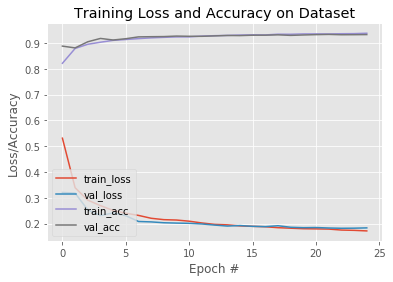

In [18]:
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), training_history["loss"], label="train_loss")
plt.plot(np.arange(0, N), training_history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training_history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), training_history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

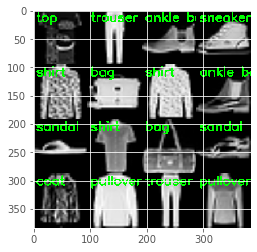

In [19]:
%matplotlib inline

# initialize our list of output images
images = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(testY)), size=(16,)):
    # classify the clothing
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
 
    # extract the image from the testData if using "channels_first"
    # ordering
    if K.image_data_format() == "channels_first":
        image = (testX[i][0] * 255).astype("uint8")
 
    # otherwise we are using "channels_last" ordering
    else:
        image = (testX[i] * 255).astype("uint8")

    # initialize the text label color as green (correct)
    color = (0, 255, 0)

    # otherwise, the class label prediction is incorrect
    if prediction[0] != np.argmax(testY[i]):
        color = (0, 0, 255)
 
    # merge the channels into one image and resize the image from
    # 28x28 to 96x96 so we can better see it and then draw the
    # predicted label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
        color, 2)
    
    # add the image to our list of output images
    images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# show the output montage
# cv2.imshow("Fashion MNIST", montage)
# cv2.waitKey(0)
plt.imshow(montage)
plt.show()

# Important Notes

Input images are assumed to be:
* Converted to grayscale.
* Segmented, such that all background pixels are black and all foreground pixels are some gray, non-black pixel intensity.
* Resized to 28×28 pixels.

Sample code for image preprocessing: 

`from keras.preprocessing.image import ImageDataGenerator`

`ImageDataGenerator.flow_from_directory(dir_path, target_size=(32, 32), classes=["cat", "dog"], batch_size=10)`

For more real world model fine-tuned from some pre-trained model, example of model pre-trained for 1000 categories:
    
```
vgg16_model = keras.application.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers:
    model.add(layer)
    
model.pop() # Removes the last layer (softmax for 1000 categories)

# Prevents layers from being re-trained (only new layers should be trained)
for layer in model.layers:
    layer.trainable = False
    
# New layer for custom number of categories
model.add(Dense(400, activation="softmax"))

```

More on fine-tunning: https://youtu.be/INaX55V1zpY